In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np

In [3]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2024-01-11 15:54:49.126724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 15:54:49.126765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 15:54:49.128016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '../logging/proposals/'
run_name = 'cerulean-violet-74'  # 'pretty-aardvark-45'

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [6]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

In [7]:
import orbax

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = orbax.checkpoint.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)
ckpt_mgr = orbax.checkpoint.CheckpointManager(f"{ckpt_dir}/ckpts/", orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()), mgr_options)

restore_args = flax.training.orbax_utils.restore_args_from_target(state, mesh=None)
restored_state = ckpt_mgr.restore(ckpt_mgr.latest_step(), items=state, restore_kwargs={'restore_args': restore_args})

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [8]:
from utils.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

In [9]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [10]:
from dm_pix import center_crop

In [11]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1,)
    norm_vec2 = np.linalg.norm(vec2, axis=-1,)
        
    return np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)

## Text-to-image retrieval

In [12]:
from tqdm import tqdm

In [13]:
files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")

In [26]:
from utils.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False, caption_type="summary")
batches = iter(ds)

In [18]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []
captions_feat_stack = []

ii = 0
for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=77)

    captions_feat = jax.jit(model.get_text_features)(inputs_images['input_ids'], inputs_images['attention_mask'], params=restored_state.params)
    captions_feat_stack.append(captions_feat)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

    ii += 1
    if ii == 100:
        break

 99%|██████████████████████████████████████████████████████████▍| 99/100 [16:57<00:10, 10.28s/it]


In [19]:
# [captions_stack[idx] for idx in sorted_idxs_list[1]][:3]

## Base model

In [20]:
batches = iter(ds)

In [21]:
image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []
captions_feat_base_stack = []

ii = 0
for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_base_stack += captions

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=77)

    captions_feat = jax.jit(model.get_text_features)(inputs_images['input_ids'], inputs_images['attention_mask'], params=state.params)
    captions_feat_base_stack.append(captions_feat)

    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

    ii += 1
    if ii == 100:
        break

 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:55<00:03,  3.59s/it]


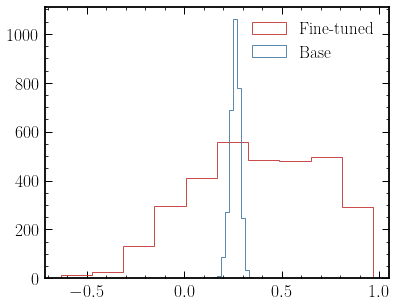

In [22]:
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)), histtype='step', label="Fine-tuned")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_stack), np.vstack(captions_feat_base_stack)), histtype='step', label="Base")

plt.legend()

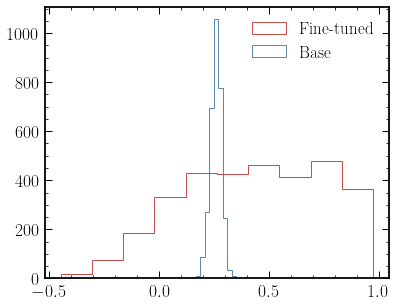

In [199]:
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)), histtype='step', label="Fine-tuned")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_stack), np.vstack(captions_feat_base_stack)), histtype='step', label="Base")

plt.legend()

In [200]:
idxs_least = np.argsort(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)))

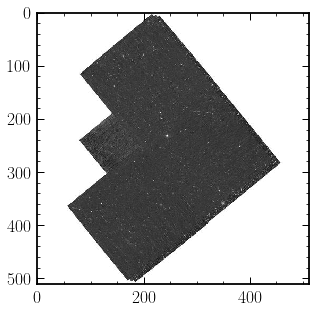

In [214]:
def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

plt.imshow(get_image_from_stack(images_stack, idxs_least[5]))

In [213]:
captions_stack[idxs_least[5]]

"quasars, star-forming galaxies, active galactic nuclei, supernovae, Milky Way stars; study quasar spectra for insight into supermassive black holes, analyze star formation in distant galaxies, investigate physics of active galactic nuclei, measure supernova redshifts for cosmological distance measurements, examine Milky Way's stellar populations for age and composition"

In [210]:
idxs_least

Array([1847, 2682, 1844, ...,  191,  187, 2987], dtype=int32)

In [14]:
from utils.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="train", shuffle=True, caption_type="summary")
batches = iter(ds)

In [15]:
images, captions = next(batches)

# Assuming images and captions are already loaded
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [16]:
import pandas as pd


# Loading the dataframes
sum1_filename = "../data/summary_sum1_v2.csv"
sum1_df = pd.read_csv(sum1_filename)

summaries_filename = "../data/summary_v2.csv"
summaries_df = pd.read_csv(summaries_filename)

# Merging the dataframes
sum_merged = pd.merge(summaries_df, sum1_df, on='proposal_id')

# Function to process each caption
def get_objects_phenomena(caption):
    first_part = caption.split(';')[0]
    match = sum_merged[sum_merged['objects_phenomena_x'] == first_part]['objects_phenomena_y']
    return match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"

# Apply the function to all captions
results = pd.Series(captions).apply(get_objects_phenomena)
list(results.values)

['spiral galaxies',
 'High-redshift galaxies',
 'Active galactic nuclei',
 'Asymptotic giant branch stars',
 'High-redshift galaxies',
 'Stellar clusters',
 'Cluster-sized over-density',
 'Type Ia supernovae',
 'Star-forming galaxies',
 'Stellar populations',
 'Active galactic nuclei',
 'calibration or instrumention',
 'Radio-pulsars',
 'Exoplanet transits',
 'Galaxy clusters',
 'Star-forming galaxies',
 'MgII absorption systems',
 'Planetary nebulae',
 'Star-forming galaxies',
 'Type Ia supernovae',
 'Stellar clusters',
 'spiral galaxies',
 'Stellar clusters',
 'Galaxy clusters',
 'Cluster-sized over-density',
 'Stellar clusters',
 'Stellar populations',
 'Globular clusters',
 'Stellar populations',
 'Stellar clusters',
 'Exoplanetary atmospheres',
 'High-redshift galaxies']

In [17]:
image_feat_stack = []
images_stack = []
captions_stack = []
captions_feat_stack = []

ii = 0

batches = iter(ds)
for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]

    captions_sum1 = []
    for caption in captions:
        sum1 = sum_merged[sum_merged['objects_phenomena_x'] == caption.split(';')[0]]['objects_phenomena_y'].values[0]
        if sum1 is np.nan:
            sum1 = "None"
        captions_sum1 += [sum1]
        
    captions_stack += captions_sum1

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions_sum1, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=77)

    captions_feat = jax.jit(model.get_text_features)(inputs_images['input_ids'], inputs_images['attention_mask'], params=restored_state.params)
    captions_feat_stack.append(captions_feat)

    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

    ii += 1
    if ii == 100:
        break

 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [05:55<00:03,  3.60s/it]


In [21]:
image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []
captions_feat_base_stack = []

ii = 0

batches = iter(ds)
for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]

    captions_sum1 = []
    for caption in captions:
        sum1 = sum_merged[sum_merged['objects_phenomena_x'] == caption.split(';')[0]]['objects_phenomena_y'].values[0]
        if sum1 is np.nan:
            sum1 = "None"
        captions_sum1 += [sum1]
        
    captions_base_stack += captions_sum1

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions_sum1, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=77)

    captions_feat = jax.jit(model.get_text_features)(inputs_images['input_ids'], inputs_images['attention_mask'], params=state.params)
    captions_feat_base_stack.append(captions_feat)

    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

    ii += 1
    if ii == 100:
        break

 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [05:39<00:03,  3.43s/it]


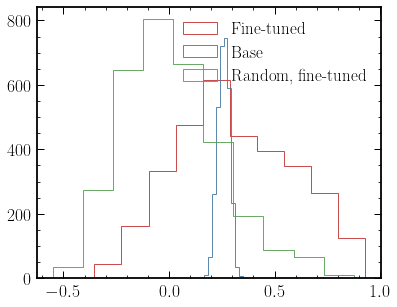

In [22]:
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)[:]), histtype='step', label="Fine-tuned")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_stack), np.vstack(captions_feat_base_stack)), histtype='step', label="Base")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), jax.random.permutation(jax.random.PRNGKey(42), np.vstack(captions_feat_stack)[:])), histtype='step', label="Random, fine-tuned")

plt.legend()

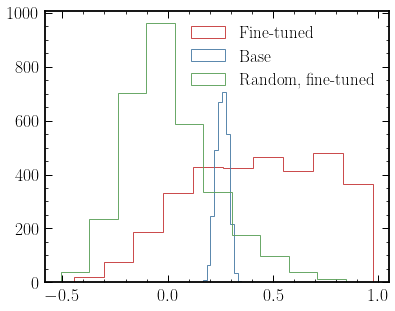

In [265]:
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)[:3185]), histtype='step', label="Fine-tuned")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_stack), np.vstack(captions_feat_base_stack)), histtype='step', label="Base")
plt.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), jax.random.permutation(jax.random.PRNGKey(42), np.vstack(captions_feat_stack)[:3185])), histtype='step', label="Random, fine-tuned")

plt.legend()